<a href="https://colab.research.google.com/github/GiselaCS/Mujeres_Digitales/blob/main/4)_Modelo_Lineal_Transformaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Cuánto deberían valer las propiedades en Milwaukee, Wisconsin? 

## Metas (3 min)
El famoso estadístico George E.P. Box una vez dijo:

$$
\textbf{"Todos los modelos son incorrectos, pero algunos modelos son útiles."}
$$

Nuestro mundo se comporta de acuerdo con tantas variables que están fuera de nuestro control, que esperar que un modelo simple *perfectamente* explique estos matices es imposible. Sin embargo, podemos intentar mitigar este problema mejorando nuestra comprensión de los errores que están produciendo nuestros modelos. Esto nos permite actualizar el modelo en consecuencia y poder mejorar su utilidad.

El objetivo principal de este caso es aprender a realizar un análisis adecuado de los errores (residuales) de los modelos de regresión lineal y cómo utilizar este análisis para realizar mejoras en el modelo. Verá nuevamente cómo las transformaciones de variables y un estudio de valores atípicos en los residuos pueden ayudar con esta tarea.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en drive
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive
/content


In [ ]:
%cd '/content/gdrive/MyDrive/Bootcamp SENA 2021/Semana 9/'

/content/gdrive/MyDrive/Bootcamp SENA 2021/Semana 9


In [1]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.formula.api as smf
import statsmodels.api         as sm
import scipy

%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Introducción (5 min)

**Contexto comercial** Los mercados de bienes raíces a veces pueden ser irracionales, y comprar una casa ciertamente puede ser un proceso emocional y altamente psicológico. Por ejemplo, el precio de venta puede [“anchor”](https://en.wikipedia.org/wiki/Anchoring) las negociaciones, y puede ser muy difícil como comprador “olvidar” ese número inicial.

Eres un promotor inmobiliario que compra propiedades con frecuencia. Sería muy útil obtener una estimación justa del precio de una propiedad antes de ver el precio de venta, basándose en características como su tamaño y ubicación. Además de convertirlo en un comprador más informado, tener un modelo de precios podría tener múltiples usos, como detectar automáticamente las propiedades con precio inferior al mercado que salen al mercado o estimar el valor agregado de una propiedad si se amplía, se divide en apartamentos o se convierte en oficinas.

**Problema comercial** Su tarea es **crear un modelo para predecir los precios de las propiedades en la ciudad de Milwaukee, Wisconsin**.

**Contexto analítico** El conjunto de datos consta de ventas de propiedades (comerciales y residenciales) en Milwaukee, Wisconsin, de 2002 a 2018. La regresión lineal es una idea simple: al final del día, solo estamos ajustando una línea a través de los datos. Pero su simplicidad es también su fortaleza: los coeficientes son fácilmente interpretables y es sencillo comprender el modelo subyacente. Sin embargo, muchas cosas pueden salir mal durante el proceso de ajuste de un modelo lineal.

El caso está estructurado de la siguiente manera: 1) explorará los datos para recoger algunos patrones iniciales; 2) analizar **residuales**, la diferencia entre los valores reales y sus estimaciones, para diagnosticar un modelo inicial; 3) realizar transformaciones de variables para tratar parcialmente los problemas; y finalmente 4) ver cómo lidiar con los valores atípicos para mejorar aún más el modelo.

## Exploración de data (25 min)

Miremos las variables disponibles:
1. **PropType**: the property category (“Commercial”, “Residential”, “Lg Apartment”, “Vacant Land”, or “Condominium”)
2. **Taxkey**: a unique identifier for the property
3. **Address**: the street address of the property
4. **CondoProject**: for condominiums, the name of the project
5. **District**: integer between 1 and 15 identifying the city district
6. **Nbhd**: integer identifying one of 591 neighborhoods
7. **Style**: information about the building architectural style, commerical use or type of building
8. **Extwall**: type of exterior wall (e.g. “Brick”)
9. **Stories**: number of stories
10. **Year_Built**: the year the building was built
11. **Nr_of_rms**: number of rooms
12. **Fin_sqft**: finished square feet
13. **Units**: number of units (e.g. apartments) in the building
14. **Bdrms**: number of bedrooms
15. **Fbath**: number of full bathrooms
16. **Hbath**: number of half bathrooms
17. **Lotsize**: size of the lot in square feet
18. **Sale_date**: the date of the sale in YYYY-MM-DD format
19. **Sale_price**: sale price in US dollars

In [2]:
data = pd.read_csv("2002-2018-property-sales-data.csv",
    dtype = { # indicate categorical variables
        "PropType": "category",
        "District": "category",
        "Extwall": "category",
        "Nbhd": "category",
        "Style": "category",
    },
    parse_dates=["Sale_date"], # the Sale_date column is parsed as a date
)
data.head()

,PropType,Taxkey,Address,CondoProject,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price
0,Commercial,3230461110,2628 N 6TH ST,NaN,6,6258,Commercial Exempt,NaN,2.0,1880,0,1840,1,0,0,0,12750,2002-01-01,15900
1,Commercial,3590192000,1363 N PROSPECT AV,NaN,3,6262,Mansions With Commercial Usage,NaN,2.0,1876,0,6377,1,0,0,0,11840,2002-01-01,850000
2,Commercial,4161194000,617 S 94TH ST,NaN,10,6272,Service Building,NaN,1.0,1954,0,5022,1,0,0,0,9700,2002-01-01,119000
3,Commercial,1719836000,3624 W SILVER SPRING DR,NaN,1,6218,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1955,0,6420,1,0,0,0,8792,2002-01-01,210000
4,Commercial,3480290000,3830 W LISBON AV,NaN,15,6254,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1909,0,5956,1,0,0,0,4840,2002-01-01,48500


In [3]:
data.shape
data.isnull().sum()

PropType            3
Taxkey              0
Address             0
CondoProject    27867
District            0
Nbhd                0
Style               6
Extwall          9899
Stories             0
Year_Built          0
Nr_of_rms           0
Fin_sqft            0
Units               0
Bdrms               0
Fbath               0
Hbath               0
Lotsize             0
Sale_date           0
Sale_price          0
dtype: int64

A veces, los números que faltan se ingresan como ceros, lo que puede estropear el análisis (consulte "Tamaño de lote" a continuación como ejemplo).
Antes de continuar, eliminaremos las filas con ceros en `Year_Built`,` Fin_sqft`, `Lotsize` y` Sale_price`, ya que estas son las variables numéricas donde los valores cero erróneos pueden sesgar la distribución:

Text(0, 0.5, 'count')

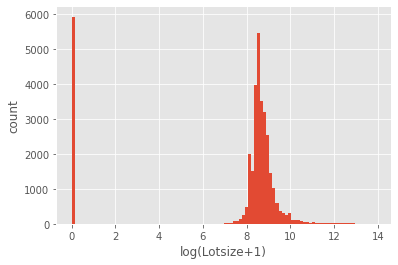

In [4]:
plt.hist(np.log(data["Lotsize"]+1), bins=100)
plt.xlabel("log(Lotsize+1)")
plt.ylabel("count")

Con el fin de eliminar de consideración los posibles factores de confusión, nos centraremos únicamente en las propiedades residenciales (las propiedades comerciales están sujetas a todo tipo de fuerzas económicas y de mercado que las propiedades residenciales no lo están):

In [5]:
def remove_unused_categories(data):
    """  `remove_unused_categories` es un método en pandas
         elimina categorías de una serie si no hay
         elementos de esa categoría.
        
         Esta función es una función de conveniencia que elimina
         categorías no utilizadas para todas las columnas categóricas
         de un marco de datos.
        
         La razón por la que esto es útil es que cuando
         ajustar una regresión lineal, `statsmodels`
         crear un coeficiente para cada categoría en una columna,
         y las categorías no utilizadas contaminan los resultados.
    """
    for cname in data:
        col = data[cname]
        if pd.api.types.is_categorical_dtype(col):
            data[cname] = col.cat.remove_unused_categories()
    return data

clean = np.where(
    #filtramos precio de venta mayor a 0 
    (data["Sale_price"] > 0) & #el añor de construccion mayor a 1800
    (data["Year_Built"] > 1800) & #el area construida sea mayor a 0
    (data["Fin_sqft"] > 0) & # mayor a 0
    (data["Lotsize"] > 0)  & # mayor a 0
    (data["PropType"] == "Residential")#solo datos residenciales 
    )
#tomamos el df y le aplicamos la mascaa que creamos antes, y se crea una copia
data_clean = data.iloc[clean].copy()
#para liberar la memoria al df le removemos las categorias que no se usan.
remove_unused_categories(data_clean).head()

,PropType,Taxkey,Address,CondoProject,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price
10,Residential,3080013000,3033 N 35TH ST,NaN,7,2960,AP 1,Frame,2.0,1913,0,3476,4,9,1,0,5040,2002-02-01,42000
51,Residential,3190434000,1908 E WEBSTER PL,NaN,3,3170,Rm or Rooming House,Frame,2.0,1897,0,1992,4,2,2,0,2880,2002-05-01,145000
67,Residential,3891722000,812 N 25TH ST,NaN,4,3040,Rm or Rooming House,Frame,2.0,1907,0,2339,6,0,1,0,3185,2002-06-01,30000
116,Residential,3880628000,959 N 34TH ST,NaN,4,2300,AP 1,Frame,2.0,1890,0,2329,4,4,1,0,5781,2002-10-01,66500
134,Residential,3880406000,3209 W WELLS ST,NaN,4,2300,Mansion,Stone,2.5,1891,0,7450,2,7,6,0,15600,2002-11-01,150500


In [6]:
data_clean.shape

(24450, 19)

### Ejercicio 1: (15 min)

#### 1.1

Escribe código para visualizar la relación entre el logaritmo del precio de venta por pie cuadrado (`Fin_sqft`) y las siguientes variables:

1. the number of units (C)
2. the year the building was built 
3. the city district (C)
4. the logarithm of the finished square footage
5. the number of bedrooms (C)
6. the sale date

Para las variables categóricas, puede ser útil utilizar **gráficos de violín**, que primero separa los datos por categoría y luego muestra la distribución de la variable $y$ como un histograma suave para cada categoría.

**Sugerencia:** Puede usar la función seaborn ``sns.violinplot(x, y, data)``. Para este ejercicio, dibuje diagramas de violín para las variables con una (C) como se muestra arriba.

**Solución.** 

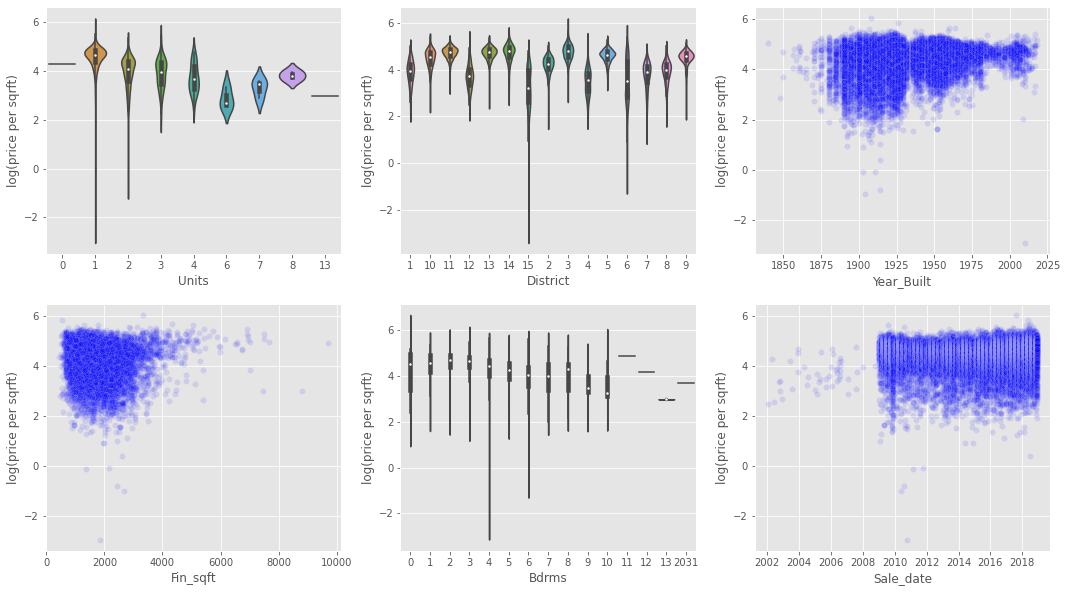

In [7]:

varstolook = ["Units", "District", "Year_Built", "Fin_sqft", "Bdrms", "Sale_date"]
data_clean2=data_clean.copy()
data_clean2['log(price per sqrft)']=np.log(data_clean["Sale_price"] / data_clean["Fin_sqft"])

plt.figure(figsize=(18,10))
for i,var in enumerate(varstolook):
    plt.subplot(2,3,i+1)
    if var in ['Units','District','Bdrms']:
        sns.violinplot(x=var, y='log(price per sqrft)', data=data_clean2)
    else:
        sns.scatterplot(x=var,y='log(price per sqrft)',data=data_clean2, alpha=0.10,color='b')
        

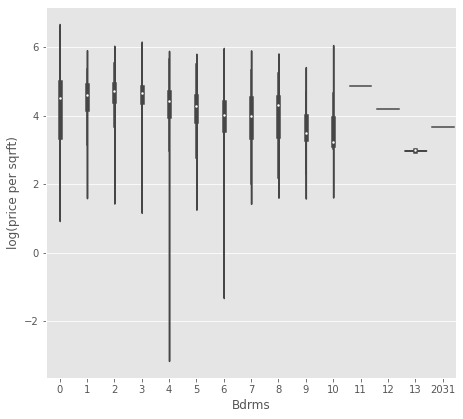

In [16]:
#numero de habitaciones en grafica de violin
varstolook1 = ["Bdrms"]
data_clean2=data_clean.copy()
data_clean2['log(price per sqrft)']=np.log(data_clean["Sale_price"] / data_clean["Fin_sqft"])

plt.figure(figsize=(25,15))
for i,var in enumerate(varstolook1):
    plt.subplot(2,3,i+1)
    if var in ['Bdrms']:
        sns.violinplot(x=var, y='log(price per sqrft)', data=data_clean2)
    else:
        sns.scatterplot(x=var,y='log(price per sqrft)',data=data_clean2, alpha=0.10,color='b')
        

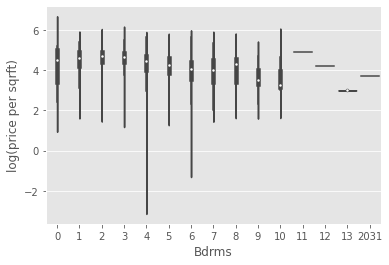

In [20]:
sns.violinplot(x='Bdrms', y = 'log(price per sqrft)', data= data_clean2)

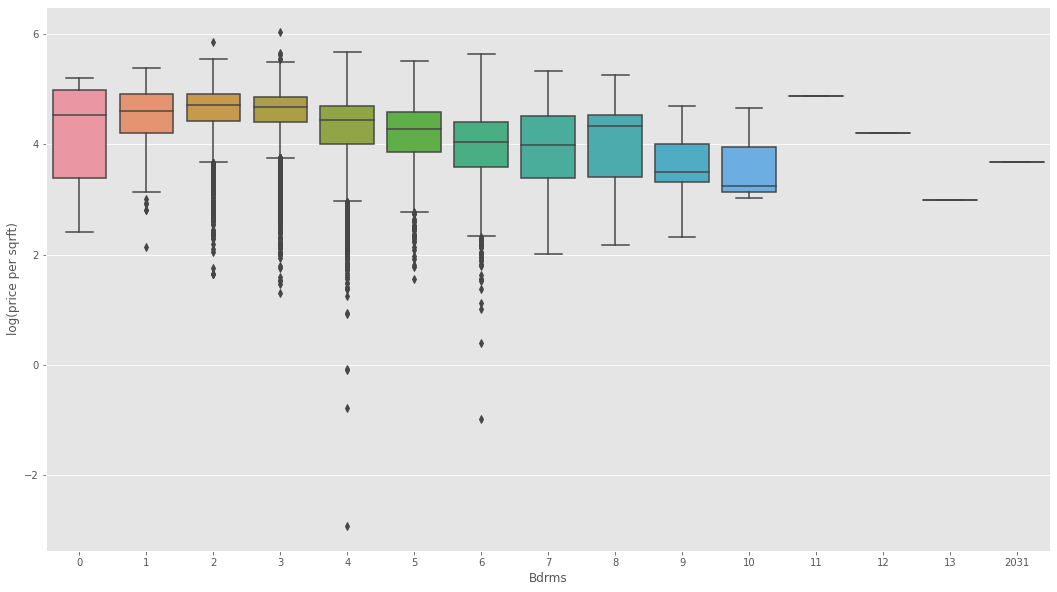

In [24]:
plt.figure(figsize=(18,10))
sns.boxplot(x='Bdrms', y = 'log(price per sqrft)', data= data_clean2)

#### 1.2

¿Qué puede concluir de estas parcelas exploratorias? Seleccione todas las que correspondan.

(a) Las propiedades construidas en los últimos diez años tienden a ser más valiosas (por pie cuadrado)

(b) Dividir una propiedad de una sola unidad en unidades más pequeñas tendería a hacerla más valiosa

(c) Muchas de las propiedades más valiosas se encuentran en los distritos 3 y 14

(d) Tener más dormitorios hace que una propiedad sea menos valiosa

**Respuesta.**

(a) Falso. Algunas de las propiedades más valiosas (pero también algunas de las propiedades *menos* valiosas son más antiguas. No hay una tendencia claramente discernible.

(b) Falso. Si bien esto puede ser cierto, no se puede ver solo en estas tramas. De hecho, las parcelas muestran que las propiedades con más unidades son típicamente *menos* valiosas por pie cuadrado que las propiedades de una sola unidad. Puede ser razonable inferir que los residentes de Milwaukee tienen una marcada preferencia por vivir en sus propias casas. Pero las propiedades de una y varias unidades difieren de otras maneras (por ejemplo, pueden estar concentradas en diferentes vecindarios), lo que hace que sea imposible sacar conclusiones sólidas de esta parcela por sí sola.

(c) Verdadero. De hecho, las colas superiores de la trama del violín para los distritos 3 y 14 se extienden más allá de los otros distritos. Entonces esos distritos tienen algunas de las propiedades más valiosas, al menos por metro cuadrado. Un vistazo rápido a un [mapa](https://city.milwaukee.gov/ImageLibrary/Groups/electionAuthors/howtorun/maps/newdistrictmap2012.jpg) de los distritos muestra que ambos están cerca del lago Michigan y a poca distancia del distrito central de negocios (Distrito 4).

(d) Falso. Si bien esto puede parecer cierto a partir de la trama, es razonable sospechar que las propiedades con muchos dormitorios son más grandes y tienen varias unidades, lo que *confunde* la tendencia que se ve aquí.

### Ejercicio 2: (5 min)

Proporcione el código para ajustar una regresión lineal múltiple del precio de venta contra el distrito, el número de unidades y los pies cuadrados terminados. ¿Qué distritos reconoce el modelo como los que tienen las propiedades más valiosas? ¿Son todos los coeficientes significativos? Si no es así, ¿cómo deberíamos interpretar los coeficientes con un valor $p$ alto?

**Respuesta**

In [25]:
model_lin = smf.ols(formula = "Sale_price ~ District + Units+ Fin_sqft", 
                 data = data_clean).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             Sale_price   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     3165.
Date:                Mon, 27 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:26:57   Log-Likelihood:            -2.9839e+05
No. Observations:               24450   AIC:                         5.968e+05
Df Residuals:                   24433   BIC:                         5.969e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.148e+04   1775.106     12.

In [28]:
modelo_lineal = smf.ols(formula = "Sale_price ~ District + Bdrms+ Fin_sqft", 
                 data = data_clean).fit()
print(modelo_lineal.summary())

                            OLS Regression Results                            
Dep. Variable:             Sale_price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     2121.
Date:                Mon, 27 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:28:14   Log-Likelihood:            -3.0146e+05
No. Observations:               24450   AIC:                         6.030e+05
Df Residuals:                   24433   BIC:                         6.031e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.446e+04   1914.450    -12.

El modelo reconoce los Distritos 3 y 14 como los que tienen las propiedades más valiosas. Esto concuerda con nuestros hallazgos del ejercicio 1. Además, vemos que los coeficientes de los distritos 12 y 8 no son significativos. Concluimos que no existe una diferencia estadísticamente significativa entre los precios de las propiedades de los Distritos 1 y 8, y los Distritos 1 y 12, *una vez que se toma en cuenta* la cantidad de unidades y los pies cuadrados de las propiedades.

## Inspección de residuos para diagnosticar un modelo ajustado (30 min)

La regresión lineal es conceptualmente simple; después de todo, solo estamos ajustando una línea a través de nuestros datos, pero muchas cosas pueden salir mal. **El análisis de residuos** es una herramienta importante para diagnosticar muchos problemas que pueden afectar una regresión lineal.
Los "residuales" son la diferencia entre las observaciones $y$ y los valores ajustados correspondientes $\hat{y}$;
visualmente es la distancia entre la línea ajustada y los puntos de datos.

El análisis residual nos permite probar algunos de los supuestos teóricos que sustentan la regresión lineal. La versión corta es que la regresión lineal funciona mejor cuando los residuos son idénticos [distribuidos normalmente](https://en.wikipedia.org/wiki/Normal_distribution). Es posible que haya encontrado declaraciones antes de afirmar que "la regresión lineal asume que los datos están distribuidos normalmente", lo cual no es del todo correcto. La regresión lineal puede ser una herramienta útil y poderosa (¡y teóricamente justificada!) Incluso si los datos se desvían de esta suposición . Dicho esto, una distribución con colas gruesas es un problema particular para la regresión lineal, porque los puntos "en las colas" que están lejos de sus valores ajustados pueden afectar de manera desproporcionada los coeficientes ajustados y las predicciones. Incluso un solo punto, que podría por ejemplo, ser causado por un punto decimal mal colocado cuando los datos sin procesar fueron ingresados ​​manualmente en una hoja de cálculo por un empleado distraído, puede causar estragos en un modelo. Se dice que dicho punto de datos tiene un alto **apalancamiento** en el modelo.

### Ejercicio 3: (15 min)

#### 3.1

Obtenga los residuales comparando las observaciones con los valores ajustados (`model_lin.fittedvalues`). Compruebe que recupera los mismos valores que los almacenados en `model_lin.resid`.

**Respuesta.** El software estadístico calcula convenientemente muchas cosas para nosotros. Pero al aprender una nueva herramienta, es útil verificar que comprendemos de dónde provienen estos números. Este es un pequeño ejemplo de este principio, en el que nos aseguramos de saber cómo calcular los residuos, aunque también estén disponibles directamente como un atributo del objeto modelo. Tenga en cuenta que, a su vez, los valores ajustados podrían haberse obtenido "manualmente" como `model_lin.predict (data_clean)`.

In [29]:
my_resid = data_clean.Sale_price - model_lin.fittedvalues
# chequear las diferencias entre los residuales y
# los valores pre computados 
np.allclose(my_resid, model_lin.resid) # Deberia mostrar True

True

#### 3.2

Trace un histograma y un gráfico QQ de los residuos. ¿Que notaste?
    
**Sugerencia:** Para comparar el histograma de residuos con una distribución normal, use el argumento ```density = True``` de ```plt.hist```, que coloca el histograma en la misma escala que la normal distribución. Luego, agregue el código:

```
xx = np.linspace (model_lin.resid.min (), model_lin.resid.max (), num = 1000)
plt.plot (xx, scipy.stats.norm.pdf (xx, loc = 0.0, scale = np.sqrt (model_lin.scale)),
     label = "distribución normal")
```
para superponer la función de densidad de probabilidad de la distribución normal.

Para visualizar los valores atípicos en el histograma, podemos usar la función `rugplot ()` en la biblioteca `seaborn`. Para el propósito de este ejercicio, defina los valores atípicos como aquellos residuales que están a más de cuatro desviaciones estándar de cero.

**Respuesta.** 

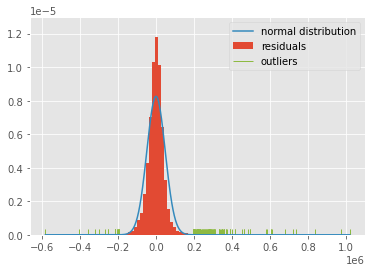

In [30]:
plt.hist(model_lin.resid, 
    density=True,     # 
                      # 
    bins=100,         # 
    label="residuals" # 
    )
# 
xx = np.linspace(model_lin.resid.min(), model_lin.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_lin.scale)),
    label="normal distribution")
outliers = np.abs(model_lin.resid)>4*np.sqrt(model_lin.scale)
sns.rugplot(model_lin.resid[outliers],
            color="C5", # 
            label="outliers")
plt.legend(loc="upper right");

Inmediatamente notamos algunas cosas:

1. El pico de los residuos es más alto que la distribución normal.
2. La mayor parte de la distribución de los residuos es más estrecha que la distribución normal.
3. Hay algunos valores atípicos importantes en ambos lados
4. Los residuos no son simétricos; es decir, hay algunos valores atípicos particularmente grandes en el lado derecho

**NOTA:** Aquí estamos enfatizando los diagnósticos visuales, pero hay métricas reportadas en la tabla de resumen de estadísticas para los residuos que contarán la misma historia: el [sesgo-positivo](https://en.wikipedia.org/wiki / Asimetría) y una [curtosis-alta](https://en.wikipedia.org/wiki/Kurtosis) son motivos de preocupación.

También creamos la gráfica QQ de los residuales, que muestra no linealidad y es otra señal de advertencia fuerte:

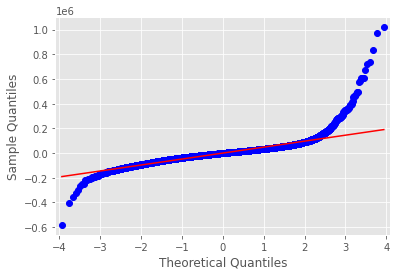

In [31]:
sm.qqplot(model_lin.resid, line="s");

Otra situación problemática que puede detectarse mediante el análisis de residuos es la **heterocedasticidad**, lo que significa que los residuos tienen una pequeña variación en algunos subconjuntos de datos y una alta variación en otros. Vimos esto exactamente desde el principio en el caso anterior, con los puntos de datos "desplegándose" alrededor de la línea de mejor ajuste, y determinamos que esto causaría problemas. Lo opuesto a heterocedasticidad es **homocedasticidad**, que es lo que queremos ver en los datos y significa que los residuos tienen una varianza similar en todos los subconjuntos de los datos.

### Ejercicio 4: (10 min)

#### 4.1

Supongamos que se nos dan datos de un par de casas en Milwaukee, digamos ```casa1``` y ```casa2```. Utilizamos nuestro modelo para obtener un precio de venta recomendado para cada casa. El precio devuelto para ```house1``` fue $ \$ 60,000 $ y para ```house2``` fue $\$7,000,000$. Sabemos que el precio de venta final de cada casa será diferente, ya que depende de varios otros factores no incluidos en el modelo. Al final, el precio de venta real de cada casa estará en algún intervalo
$$
\begin{aligned}
 \$60,000-\verb*std1*&\leq \verb*house1* \leq \$60,000+\verb*std1*,\\
&\\
\$7,000,000-\verb*std2* &\leq \verb*house2*\leq \$7,000,000+\verb*std2*.
\end{aligned}
$$

Que desviación esperas que sea mayor, ```std1``` or ```std2```?

**Answer.** Esperaríamos que ```std2``` sea mucho más grande que ``` std1```. De hecho, un comprador interesado en una casa que ronda los $\$60k$ probablemente sea un comprador que no tenga ingresos elevados. Por lo tanto, tendría cuidado de no gastar más de $ \$10k$ o $\$20k$ por encima de su presupuesto. En contraste, un comprador de una casa alrededor de los 7 millones probablemente tendría una flexibilidad mucho mayor en su presupuesto. Por lo tanto, para ellos, agregar un costo adicional de $ \$500k $ o más puede no importar mucho.

#### 4.2
Verifique sus hallazgos del ejercicio 4.1 dibujando una gráfica de dispersión de los residuos contra los pies cuadrados. ¿Son los residuos homocedásticos o heteroscedásticos?

**Sugerencia:** Para ver los cambios en la varianza un poco mejor, también puede subdividir los datos en `Fin_sqft` en cuatro contenedores y dibujar diagramas de violín.

**Respuesta.** 

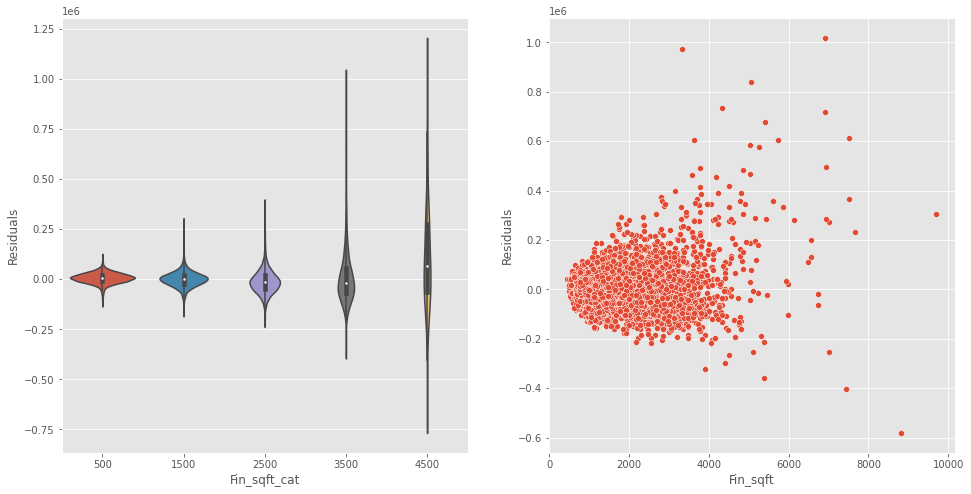

In [32]:
data_clean3=data_clean.copy()
bins = np.array([0, 1000, 2000, 3000, 4000])
data_clean3['Fin_sqft_cat']=bins[np.digitize(data_clean3['Fin_sqft'], bins)-1]+500
data_clean3['Residuals']=model_lin.resid.values

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

sns.violinplot(x='Fin_sqft_cat', y='Residuals',data=data_clean3,
               positions=(500, 1500, 2500, 3500, 4500),
               widths=700,
               showextrema=True, ax=ax[0],alpha=0.02
               )
sns.scatterplot(x='Fin_sqft',y='Residuals',data=data_clean3,ax=ax[1])

También podemos superponer el diagrama de violín sobre el diagrama de dispersión de la siguiente manera:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'residuals')

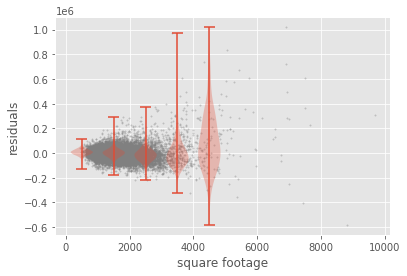

In [33]:
Fin_sqft = data_clean["Fin_sqft"]
# scatter plot de residuales:
plt.scatter(Fin_sqft, model_lin.resid, s=2, alpha=0.3, color="grey")
# violin plot de los datos con 5 bins:
bins = np.array([0, 1000, 2000, 3000, 4000])
sqft_bin = np.digitize(Fin_sqft, bins)
plt.violinplot([model_lin.resid.values[sqft_bin == ibin] for ibin in range(1,len(bins)+1)],
               positions=[500, 1500, 2500, 3500, 4500],
               widths=700,
               showextrema=True,
               )
plt.xlabel("square footage")
plt.ylabel("residuals")

Las gráficas de violín muestran que los residuos se ensanchan a medida que las propiedades aumentan, lo que demuestra heterocedasticidad.

Como nota al margen, la heterocedasticidad es fácil de mostrar, pero la homocedasticidad es difícil de demostrar, porque tenemos que demostrar que *ninguna* de las variables exhibe heterocedasticidad. En general, use su *intuición* para buscar heterocedasticidad; aquí, quizás era previsible que las casas pequeñas (y por lo tanto baratas) tuvieran un precio de venta más predecible que las casas grandes (caras).

## Transformación de variables para mitigar problemas de residuos (30 min)

Ahora que hemos visto que los residuos son problemáticos, necesitamos averiguar qué hacer con ellos. Una posible solución es tomar prestada la técnica que aprendimos en un caso anterior: tomar una transformación de la variable de respuesta. Intentemos hacer que la variable de respuesta sea el logaritmo de `Sale_price`. Es un supuesto natural que el precio de venta debe ser proporcional a los pies cuadrados de la propiedad. Por lo tanto, también tomaremos el logaritmo de los pies cuadrados como variable predictora en este modelo:

In [35]:
#dentro de la ecuacion se le pone el logaritmo 
#np en numpy, log es para sacar el logaritmo 
#el .fit() es para hacer el ajuste
model_log = smf.ols(formula = "np.log(Sale_price) ~ District + Units"
                           "+ np.log(Fin_sqft)", 
                 data = data_clean).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     2283.
Date:                Mon, 27 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:52:23   Log-Likelihood:                -10020.
No. Observations:               24450   AIC:                         2.007e+04
Df Residuals:                   24433   BIC:                         2.021e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.2346      0.057  

### Ejercicio 5: (15 min)

#### 5.1

Trace un histograma de los residuos, similar a lo que hicimos en el ejercicio 3. ¿La transformación logarítmica solucionó los problemas de asimetría y valores atípicos que notamos anteriormente?

**Sugerencia:** ¿Qué cambios en [Asimetría](https://en.wikipedia.org/wiki/Skewness) y [Kurtosis](https://en.wikipedia.org/wiki/Kurtosis) ves en el nuevo modelo?

**Respuesta.** 

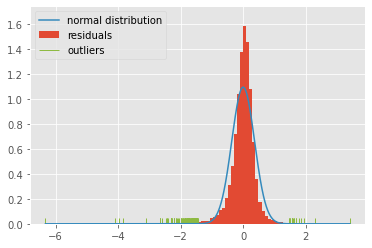

In [36]:
plt.hist(model_log.resid, 
    density=True,     # area bajo curva es 1
                      # para comparar con la dist. normal
    bins=100,         #  dibujar histograma con 100 bins de igual tamaño
    label="residuals" # label para legend
    )
# plot la dist. normal distribution para comparacion
xx = np.linspace(model_log.resid.min(), model_log.resid.max(), num=10000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_log.scale)),
    label="normal distribution")
sns.rugplot(model_log.resid[np.abs(model_log.resid)>4*np.sqrt(model_log.scale)],
            color="C5", # en otro caso el  color sera el mismo del histograma
            label="outliers")
plt.legend(loc="upper left");

Visualmente, no es obvio que los residuos hayan mejorado. Sin embargo, mirar los detalles pinta una imagen diferente. No hay menos valores atípicos, pero muchos están ahora por debajo del pico en lugar de por encima. Los valores atípicos bajos son más fáciles de explicar como productos de factores externos conocidos que los valores atípicos altos; p.ej. si el propietario vende su casa a un amigo o pariente, o si la propiedad está en condiciones particularmente malas, entonces podría venderse a un precio muy reducido.

Los residuos también están menos sesgados y las colas de la distribución tienen menos grasa. Esto se puede deducir de las métricas `Skew` y` Kurtosis` en la parte inferior de los resúmenes de los modelos (reproducidos a continuación por conveniencia):

In [37]:
model_lin.summary().tables[-1]

Omnibus:,16670.121,Durbin-Watson:,1.740
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1483125.778
Skew:,2.504,Prob(JB):,0.00
Kurtosis:,40.825,Cond. No.,3.26e+04


In [38]:
model_log.summary().tables[-1]

Omnibus:,8475.447,Durbin-Watson:,1.741
Prob(Omnibus):,0.000,Jarque-Bera (JB):,120216.866
Skew:,-1.272,Prob(JB):,0.00
Kurtosis:,13.561,Cond. No.,186.


#### 5.2

¿Mejoró el problema de la heterocedasticidad con el ejercicio 4?

**Respuesta.** 

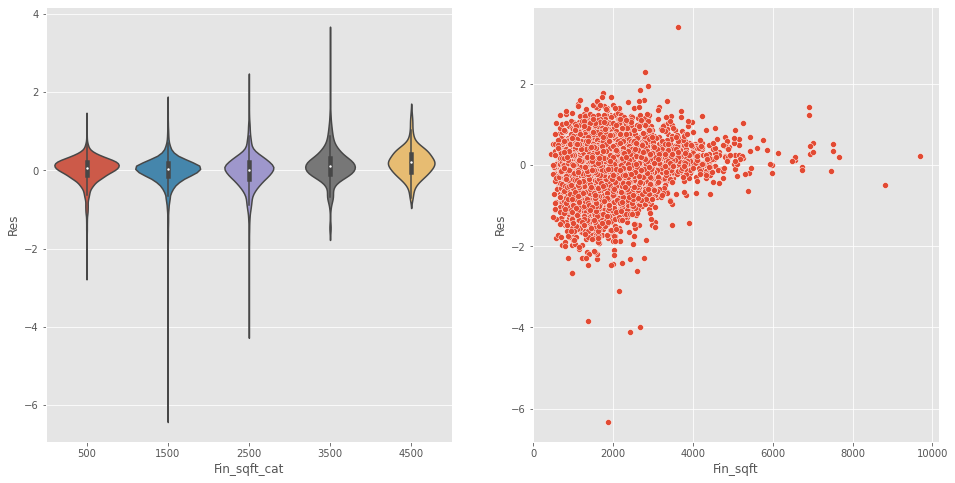

In [39]:
data_clean4=data_clean.copy()
bins = np.array([0, 1000, 2000, 3000, 4000])

data_clean4['Fin_sqft_cat']=bins[np.digitize(data_clean4['Fin_sqft'], bins)-1]+500

data_clean4['Res']=model_log.resid.values

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

sns.violinplot(x='Fin_sqft_cat', y='Res',data=data_clean4,
               positions=(500, 1500, 2500, 3500, 4500),
               widths=700,
               showextrema=True, ax=ax[0],alpha=0.02
               )
sns.scatterplot(x='Fin_sqft',y='Res',data=data_clean4,ax=ax[1])

También podemos superponer el diagrama de violín sobre el diagrama de dispersión de la siguiente manera:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


''

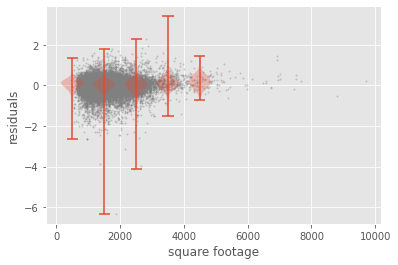

In [40]:
Fin_sqft = data_clean["Fin_sqft"]
plt.scatter(Fin_sqft, model_log.resid, s=2, alpha=0.3, color="grey")
bins = np.array([0, 1000, 2000, 3000, 4000])
sqft_bin = np.digitize(Fin_sqft, bins)
plt.violinplot([model_log.resid.values[sqft_bin == ibin] for ibin in range(1,len(bins)+1)],
               positions=[500, 1500, 2500, 3500, 4500],
               widths=700,
               showextrema=True,
               )
plt.xlabel("square footage")
plt.ylabel("residuals")
;

La distribución de los residuos en función de los pies cuadrados se ha estabilizado, lo que apoya el argumento de que la escala logarítmica es más natural para modelar los precios de las propiedades.

### Ejercicio 6: (5 min)

#### 6.1

¿Cómo interpretamos el coeficiente de "Units"?

**Respuesta** 
En igualdad de condiciones, una unidad adicional reduce el precio de registro de la propiedad en 0,35, lo que corresponde a una reducción de precio ligeramente inferior al 30% (esto se calcula como $1-e^{-0.35}$).

#### 6.2

¿Qué historia nos cuenta el coeficiente `np.log (Fin_sqft)` en este modelo?

(a) El precio de una propiedad es proporcional a sus pies cuadrados

(b) El precio de una propiedad baja con los pies cuadrados.

(c) El precio de una propiedad aumenta logarítmicamente con sus pies cuadrados

(d) El precio de una propiedad aumenta exponencialmente con sus pies cuadrados.

(e) El precio de una propiedad aumenta con los pies cuadrados, pero hay rendimientos decrecientes.

**Respuesta.** (mi). El coeficiente ajustado es 0,87, que es positivo pero menor que 1. A la luz del hecho de que hemos tomado el logaritmo de `Fin_sqft`, esto implica un crecimiento *sublineal*; es decir, el precio de una propiedad aumenta con los pies cuadrados, pero hay rendimientos decrecientes. ¿Le parece esto intuitivo o sorprendente?

## Manejo de valores atípicos (30 min)

Nuestro análisis de residuos muestra una serie de valores atípicos. Como se mencionó anteriormente, los valores atípicos bajos no son del todo inesperados; p.ej. cuando la gente vende una propiedad a amigos o familiares, o si la propiedad está en mal estado, el precio de venta podría ser significativamente más bajo de lo esperado por el modelo. No obstante, los valores atípicos pueden desestabilizar un modelo y reducir significativamente su capacidad predictiva a pesar de que solo representan un subconjunto marginal de los datos generales.

### Pregunta: (5 min)

¿Qué debe hacer un analista con los valores atípicos?

Es tentador simplemente eliminar puntos de datos con grandes residuos; sin embargo, este punto de vista adolece de un sesgo retrospectivo. Los valores atípicos con residuos elevados no se pueden determinar antes de crear el modelo, lo que significa que no se pueden eliminar por adelantado.

Por el contrario, el punto de partida siempre debe ser inspeccionar los datos sin procesar iniciales en busca de puntos de datos con valores inusualmente pequeños o grandes para ciertas características, y comprender por qué son diferentes. Si hay algo claramente mal con esos datos (como un punto decimal fuera de lugar), o si la razón de estos valores pequeños o grandes se puede explicar de manera efectiva a través de un factor externo que no es capturado por los datos en sí, entonces esto justifica su eliminación. De lo contrario, es mejor tener en cuenta estos puntos de datos durante todo el proceso de modelado y tratarlos durante el proceso de modelado en sí.

### Ejercicio 7: (10 min)

Imprima las características de la propiedad con el mayor residuo absoluto (es decir, el peor valor atípico en el conjunto de datos). Para esta propiedad, ¿cuál es el precio de venta ajustado (previsto) y real?

Busque todas las demás ventas de la misma propiedad en el conjunto de datos. ¿Puede ver una explicación para estos valores atípicos extremos?

**Respuesta:** El peor valor atípico es una casa que nuestro modelo predijo que debería venderse por alrededor de \\$56,000,
y en su lugar se vendió por \\$100. Esta misma casa se vendió 8 meses antes por \\$189,000 lo que confirma que \\$100 no es el precio real de mercado. Podría, por ejemplo, ser una transacción entre familiares.

In [41]:
#cogemos los residuales del modelo y sacamos el maximo
iworst = np.abs(model_log.resid.values).argmax()
print("predicted sale price: ${:.0f}".format(
        np.exp(model_log.fittedvalues.iloc[iworst])))
data_clean.iloc[iworst] # seleccionar el peor

predicted sale price: $56174


PropType                Residential
Taxkey                   3515031000
Address              1938 N 19TH ST
CondoProject                    NaN
District                         15
Nbhd                           3000
Style                      Colonial
Extwall            Aluminum / Vinyl
Stories                           2
Year_Built                     2010
Nr_of_rms                         0
Fin_sqft                       1860
Units                             1
Bdrms                             4
Fbath                             3
Hbath                             1
Lotsize                        5681
Sale_date       2010-10-01 00:00:00
Sale_price                      100
Name: 6484, dtype: object

In [42]:
# mostrar las ventas para esta propiedad
data_clean.loc[data_clean.Taxkey == data_clean.iloc[iworst].Taxkey,["Sale_date","Sale_price"]]

,Sale_date,Sale_price
4990,2010-02-01,189000
6484,2010-10-01,100


El gráfico de dispersión a continuación muestra los residuos frente al precio de venta de todas las propiedades en los datos. El grupo en la esquina inferior izquierda muestra las propiedades que se vendieron a un precio mucho más bajo de lo esperado por el modelo, lo que puede explicarse como transacciones por debajo de la tasa de mercado entre amigos o familiares. Esto justificaría eliminar todas las transacciones por debajo de aproximadamente $2,000 del conjunto de datos antes de volver a ejecutar el análisis:

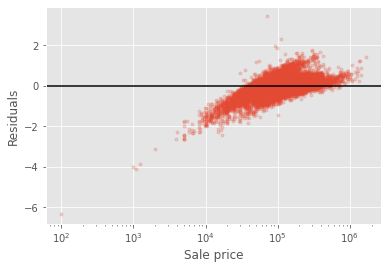

In [43]:
plt.semilogx(data_clean["Sale_price"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Sale price")
plt.axhline(0, color="black")

Podemos cuantificar el efecto de estos valores atípicos eliminándolos y volviendo a ejecutar la regresión, y viendo cómo cambian los coeficientes ajustados.

### Ejercicio 8: (15 min)

#### 8.1

Vuelva a ejecutar el mismo modelo en un conjunto de datos reducido que elimine todos los valores atípicos con residuos absolutos superiores a 1,5.

1. ¿Qué porcentaje de los datos se eliminan?
2. ¿Cuál es el valor del coeficiente de `Units` ajustado antes y después de eliminar los valores atípicos?
3. ¿Es significativa la diferencia?
4. ¿Qué coeficientes se mueven en más de dos errores estándar después de eliminar los valores atípicos?

**Solución.** 

In [44]:
# Remover outliers con residuales mayores a  1.5
# Resultados son notablemente diferentes para el coeficiente de `Units` 
# incluso cuando el 0.5% de las observaciones se remueven
outliers = np.abs(model_log.resid) < 1.5
data_noout = data_clean.loc[outliers, :]
# Reajustar el modelo con la data reducida
model_noout = smf.ols(formula = "np.log(Sale_price) ~ District + Units"
                              "+ np.log(Fin_sqft)", 
                      data = data_noout).fit()
# analizar el coeficient `Units`
print("{:.2f}% of data removed".format((1-data_noout.size/data_clean.size)*100))
print("`Units` coefficient in full model:          {:.3f}".format(model_log.params["Units"]))
print("`Units` coefficient with excluded outliers: {:.3f}".format(model_noout.params["Units"]))

0.56% of data removed
`Units` coefficient in full model:          -0.352
`Units` coefficient with excluded outliers: -0.382


In [45]:
# cuantas SE's el coeficiente cambia:
move = (model_log.params-model_noout.params)/model_log.bse
move[np.abs(move)>2] # coeficientes que se mueven mas de 2 SE's

District[T.15]   -2.044336
District[T.6]    -3.645634
Units             4.660283
dtype: float64

Este procedimiento solo elimina alrededor del 0.5% de los datos, pero el coeficiente de `Units`  cambia significativamente de $ -0.352 $ a $ -0.382 $. Esto puede no parecer mucho, pero el error estándar de este coeficiente fue 0,006, por lo que la estimación se ha desplazado en casi * cinco errores estándar *, lo que de hecho es un cambio significativo.

#### 8.2

Compruebe si las propiedades particularmente pequeñas o grandes también tienden a generar valores atípicos.

**Respuesta** No. Como se puede ver en el gráfico de residuos a continuación, no hay un grupo notable de propiedades lejos de la línea cero:

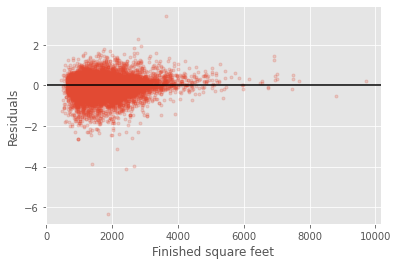

In [46]:
plt.plot(data_clean["Fin_sqft"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Finished square feet")
plt.axhline(0, color="black")

El abultamiento en el centro de la gráfica de dispersión de residuos de arriba puede parecer heterocedasticidad. Sin embargo, este efecto puede aparecer simplemente porque muchas propiedades tienen entre 1,000 y 2,000 pies cuadrados, lo que hace que el diagrama de dispersión “sobresalga” en el medio. Puede construir un diagrama de violín con los mismos datos para disipar cualquier duda sobre esta afirmación.

## Conclusiones (2 min)

Usamos la regresión lineal para predecir el precio de venta de la propiedad en Milwaukee, Wisconsin, e ilustramos algunos problemas potenciales con la regresión lineal. Cuando algunos de los supuestos de la regresión lineal se violan gravemente, como la normalidad de los residuos y la homoescedasticidad, el modelo ajustado puede desestabilizarse. Como ejemplo, vimos cómo una pequeña cantidad de valores atípicos puede cambiar un coeficiente ajustado en varios errores estándar.

## Aspectos importantes (5 min)

En este caso hemos aprendido:
    
1. Cómo reconocer la heterocedasticidad en los residuos y por qué es importante tratarla.
2. Cómo puede ser útil transformar la variable de resultado para reducir la asimetría y aliviar parte de la heterocedasticidad presente en los residuos.
3. Cómo tratar adecuadamente los valores atípicos en los residuos. Reconocimos que siempre es mejor comprender el significado de algunos de los valores atípicos para descartarlos de forma segura de nuestros modelos. En este caso, una transformación logarítmica del precio de venta alivió muchos de los problemas del modelo. Sin embargo, otros conjuntos de datos pueden invitar a diferentes transformaciones. Debe combinar la intuición y la experimentación para encontrar la transformación adecuada para usar.
5. Cómo realizar un análisis residual al utilizar la regresión lineal en sus proyectos. Como hemos visto, estos le ayudarán a mejorar no solo la calidad de sus modelos, sino también su intuición y experiencia al realizar futuros análisis de datos en el trabajo.